## Herschel-ATLAS Data Release III - Results

This notebook presents the results and analysis of the IDs to Herschel sources.

---

### Imports

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from lmfit import Model
from scipy.optimize import fsolve
from scipy.integrate import quad
from tqdm import tqdm
from astropy.table import Table
utils.rcparams()

In [2]:
# Loading the datasets
back_zHELP = utils.full_loader('output_files/Background_VIKING_KiDS_HELP_all_15')
data_zHELP = utils.full_loader('output_files/Herschel_VIKING_KiDS_HELP_all_15')
sources_zHELP_zHerschel = utils.full_loader('output_files/Herschel_VIKING_KiDS_HELP_single_15')

In [3]:
# We note that the null value for HELP datasets is -99, therefore we shall set all values of -99 to NaN. These are more easily dealt with
back_zHELP.replace(-99, np.nan, inplace = True)
data_zHELP.replace(-99, np.nan, inplace = True)
sources_zHELP_zHerschel.replace(-99, np.nan, inplace = True)

---

### Initial Statistics

In [4]:
# We compute initial statistics about the cross-matched sources and counterparts

# The number of matched counterparts
counterparts_HELP = [z for z in data_zHELP['z1_median'] if z > 0]
n_counterparts_HELP = len(counterparts_HELP)
print("Number of counterparts with a HELP match = {:.0f}".format(n_counterparts_HELP))


# The number of reliably matched sources with a HELP redshift
sources_reliable_HELP = [z for z,reliability in zip(sources_zHELP_zHerschel['z1_median'], sources_zHELP_zHerschel['reliability']) if (z > 0) & (reliability >= 0.8)]
n_sources_reliable_HELP = len(sources_reliable_HELP)
print("Number of reliable sources with a HELP match = {:.0f}".format(n_sources_reliable_HELP))

Number of counterparts with a HELP match = 542302
Number of reliable sources with a HELP match = 82195


---

### Redshifts

We realise that not all sources will have matches in the HELP catalogue, therefore, we consider the redshift of the galaxy to be that of HELP when available, otherwise we use the Herschel estimate.

In [5]:
# Defining a column for the best redshift estimate, HELP or Herschel.

best_z = []
Herschel_z = []

for i in range(len(sources_zHELP_zHerschel)):
    if not np.isnan(sources_zHELP_zHerschel['z1_median'][i]):
        best_z.append(sources_zHELP_zHerschel['z1_median'][i])
    else:
        best_z.append(sources_zHELP_zHerschel['Z_Herschel'][i])
        Herschel_z.append(sources_zHELP_zHerschel['Z_Herschel'][i])
    pass

sources_zHELP_zHerschel['z_best'] = best_z

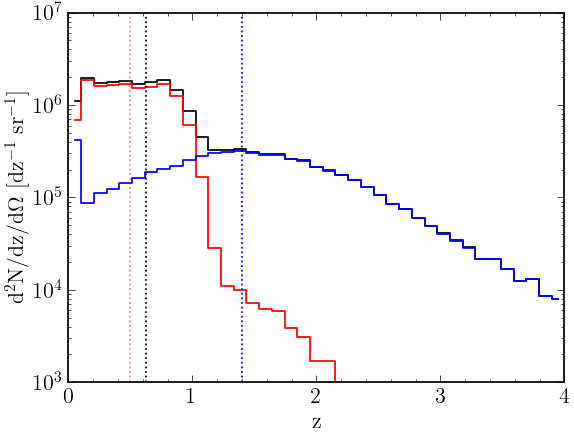

In [6]:
# Redshift distributions
survey_area = 303
min_z, max_z, z_bins = 0, 4, 40

# Determine the redshift distributions
total_z_distribution, total_z_bins = utils.dn_dz_domega(sources_zHELP_zHerschel['z_best'], min_z, max_z, z_bins, survey_area)
help_z_distribution, help_z_bins = utils.dn_dz_domega(sources_zHELP_zHerschel['z1_median'], min_z, max_z, z_bins, survey_area)
herschel_z_distribution, herschel_z_bins = utils.dn_dz_domega(Herschel_z, min_z, max_z, z_bins, survey_area)

# Plot of the different redshift distributions
plt.figure()
plt.step(total_z_bins, total_z_distribution, where = 'mid')
plt.step(help_z_bins, help_z_distribution, where = 'mid')
plt.step(herschel_z_bins, herschel_z_distribution, where = 'mid')
plt.axvline(np.nanmedian(sources_zHELP_zHerschel['z_best']), color = 'k', linestyle = ':')
plt.axvline(np.nanmedian(sources_zHELP_zHerschel['z1_median']), color = 'r', linestyle = ':', alpha = 0.5)
plt.axvline(np.nanmedian(Herschel_z), color = 'b', linestyle = ':')
plt.xlabel('z')
plt.ylabel(r'd$^2$N/dz/d$\Omega$ [dz$^{-1}$ sr$^{-1}$]')
plt.semilogy()
plt.xlim(0, 4)
plt.ylim(1e3, 1e7)
plt.yticks([1e3, 1e4, 1e5, 1e6, 1e7])
plt.savefig(os.getcwd() + '/figures/Fig_7.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

In [7]:
# Calculating the median redshifts of the distributions
HELP_z_median = np.nanmedian(sources_zHELP_zHerschel['z1_median'])
Herschel_z_median = np.nanmedian(Herschel_z)
best_z_median = np.nanmedian(sources_zHELP_zHerschel['z_best'])

print("Median redshift of HELP counterparts = {:.3f}".format(HELP_z_median))
print("Median redshift of Herschel counterparts = {:.3f}".format(Herschel_z_median))
print("Median redshift of best redshifts = {:.3f}".format(best_z_median))

# Number of redshift estimates above 5
z_best_gt5 = [z for z in sources_zHELP_zHerschel['z_best'] if z > 5]
n_z_best_gt5 = len(z_best_gt5)
print("The number of sources with best redshift > 5 = {:.0f}".format(n_z_best_gt5))

Median redshift of HELP counterparts = 0.493
Median redshift of Herschel counterparts = 1.397
Median redshift of best redshifts = 0.623
The number of sources with best redshift > 5 = 94


#### Errors on redshifts

In [8]:
# Firstly we define a mean z value which corresponds to the average of the minimum and maximum z where the 80% CI lies
back_zHELP['z1_mean'] = (back_zHELP['z1_min'] + back_zHELP['z1_max'])/2
data_zHELP['z1_mean'] = (data_zHELP['z1_min'] + data_zHELP['z1_max'])/2
sources_zHELP_zHerschel['z1_mean'] = (sources_zHELP_zHerschel['z1_min'] + sources_zHELP_zHerschel['z1_max'])/2

# We then define the error on z as the 1 sigma error corresponding to an 80% CI where 80% ~ 1.282 sigma
back_zHELP['z1_err'] = abs(back_zHELP['z1_mean'] - back_zHELP['z1_min'])/1.282
data_zHELP['z1_err'] = abs(data_zHELP['z1_mean'] - data_zHELP['z1_min'])/1.282
sources_zHELP_zHerschel['z1_err'] = abs(sources_zHELP_zHerschel['z1_mean'] - sources_zHELP_zHerschel['z1_min'])/1.282

# Let us compare the mean error on Herschel and HELP redshifts
HELP_z_mean_error = np.nanmean(sources_zHELP_zHerschel['z1_err'])
Herschel_z_mean_error = np.nanmean(sources_zHELP_zHerschel['Z_ERROR'])
print("Mean redshift error of HELP counterparts = {:.3f}".format(HELP_z_mean_error))
print("Mean redshift error of Herschel counterparts = {:.3f}".format(Herschel_z_mean_error))

Mean redshift error of HELP counterparts = 0.211
Mean redshift error of Herschel counterparts = 0.514


---

### Gravitational Lensing

#### Lensing Probabilities

We shall define a lensing probability based on the discrepancy between the HELP and Herschel redshift estimates
according to the method outlined in Gonzalez-Nuevo et al., 2019. We shall implement just the redshift probability
metric, $p_z$.

In [9]:
# Determine the lensing probabilities
lens_probabilities = utils.lensing_probabilities(sources_zHELP_zHerschel, 'Z_Herschel', 'z1_median', 'Z_ERROR', 'z1_err')
sources_zHELP_zHerschel['p_lens'] = lens_probabilities

# Determining the largest lensing probability where z(lens) > z(source)
lens_gt_source = [probability for probability,z_source,z_lens in zip(sources_zHELP_zHerschel['p_lens'], sources_zHELP_zHerschel['Z_Herschel'], sources_zHELP_zHerschel['z1_median']) if z_lens > z_source]
print('Minimum useful lensing probability = {:.3f}'.format(max(lens_gt_source)))

Calculating Lensing Probabilities: 100%|██████████| 193527/193527 [00:36<00:00, 5319.82it/s] 

Minimum useful lensing probability = 0.578


#### Optimal Lensing Threshold

Calculating the False Positive rates: 100%|██████████| 1000/1000 [01:02<00:00, 16.12it/s]


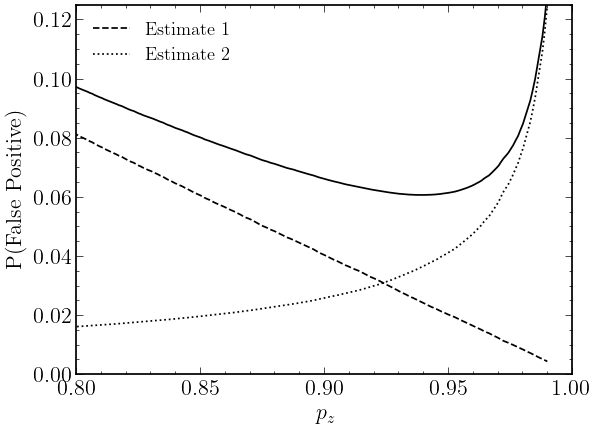

Minimum predicted false identification rate = 6.062
Lensing probability with minimum false identifications = 0.94


In [10]:
# Calculating the false positive rate for an optimal lensing threshold
p_range, false_positives, estimate_1, estimate_2, p_optimal = utils.optimal_lens_probability(sources_zHELP_zHerschel, 'reliability', 'p_lens', 'Z_Herschel', false_id_percent=4.8, n=1000)

# Plot of the false positive rate against lensing threshold
plt.figure()
plt.plot(p_range, false_positives, linestyle = '-', color = 'k')
plt.plot(p_range, estimate_1, linestyle = '--', color = 'k', label = 'Estimate 1')
plt.plot(p_range, estimate_2, linestyle = ':', color = 'k', label = 'Estimate 2')
plt.xlabel(r'$p_{z}$')
plt.ylabel(r'P(False Positive)')
plt.xlim(0.8, 1)
plt.ylim(0, 0.125)
plt.legend()
plt.savefig(os.getcwd() + '/figures/Fig_10.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

print('Minimum predicted false identification rate = {:.3f}'.format(min(false_positives)*100))
print('Lensing probability with minimum false identifications = {:.2f}'.format(p_optimal))

#### > 100mJy Sample

We take particular interest to those objects whose flux density at 500um is greater than 100 mJy. These objects are
clear candidates for lensing (reaching ~90% of true lenses when contaminants such as radio sources and local galaxies
are removed). We therefore isolate these objects.

We know that this set will be contaminated with local galaxies and blazars. We previously searched this set to get a
list of blazars and variable stars. We take a cut of S250/S350 < 1.5 to define objects far enough away to not be local
galaxies and then remove our list of blazars and variable stars.

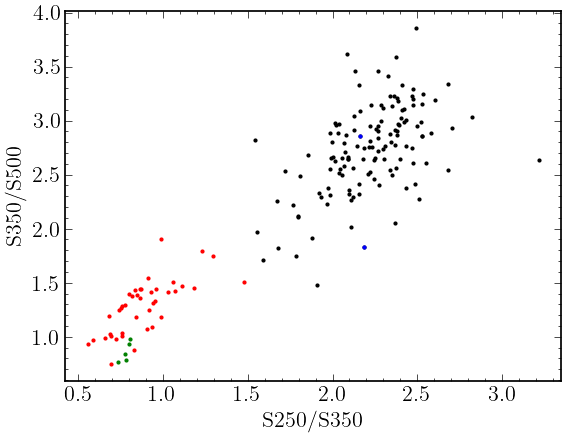

The number of >100 mJy lensed candidates = 41


In [11]:
# Separate local galaxies, stars and blazars
gt100mjy_sample = sources_zHELP_zHerschel[sources_zHELP_zHerschel['F500BEST'] > 0.1]
lensed_candidates_gt100, local_galaxies, var_stars, blazars = utils.clean_lensed_candidates(gt100mjy_sample, 'F250BEST', 'F350BEST', 'HATLAS_IAU_ID',
                                var_stars = ['HATLASJ012658.0-323234', 'HATLASJ225519.6-293644'],
                                blazars = ['HATLASJ014310.0-320056', 'HATLASJ014503.4-273333',
                                           'HATLASJ222321.6-313701', 'HATLASJ224838.6-323551',
                                           'HATLASJ235347.4-303746'])

# Colour-colour plot for the S500 > 100 mJy sample
plt.figure()
plt.scatter(local_galaxies['F250BEST']/local_galaxies['F350BEST'], local_galaxies['F350BEST']/local_galaxies['F500BEST'], s = 4)
plt.scatter(lensed_candidates_gt100['F250BEST']/lensed_candidates_gt100['F350BEST'], lensed_candidates_gt100['F350BEST']/lensed_candidates_gt100['F500BEST'], s = 4)
plt.scatter(var_stars['F250BEST']/var_stars['F350BEST'], var_stars['F350BEST']/var_stars['F500BEST'], s = 4)
plt.scatter(blazars['F250BEST']/blazars['F350BEST'], blazars['F350BEST']/blazars['F500BEST'], s = 4)
plt.xlabel('S250/S350')
plt.ylabel('S350/S500')
plt.savefig(os.getcwd() + '/figures/Fig_9.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

# Print the number of lensed candidates >100 mJy
print('The number of >100 mJy lensed candidates = {}'.format(len(lensed_candidates_gt100)))

In [12]:
# Statistics on our high-z lensed candidates

# Number of high-z lensed candidates with R > 0.8
highz_lens_reliable = [reliability for reliability in lensed_candidates_gt100['reliability'] if reliability >= 0.8]
n_highz_lens_reliable= len(highz_lens_reliable)
print("The number of the >100mJy lens candidates with R > 0.8 = {:.0f}".format(n_highz_lens_reliable))

# Determining the mean lens probability of high-z lensed candidates
lensed_candidates_meanp = np.nanmean(lensed_candidates_gt100['p_lens'])
print("Mean lens probability of the >100 mJy lens candidates = {:.3f}".format(lensed_candidates_meanp))

The number of the >100mJy lens candidates with R > 0.8 = 24
Mean lens probability of the >100 mJy lens candidates = 0.885


#### < 100mJy Sample

In [13]:
# Generate the < 100 mJy lensed candidate sample
lensed_candidates_lt100  = utils.lens_split(sources_zHELP_zHerschel, 'F500BEST', 'reliability', 'p_lens', lens_probability_thresh = p_optimal)
print('The number of <100 mJy lensed candidates = {}'.format(len(lensed_candidates_lt100)))

# Combine both <100 mJy sample and >100 mJy sample
lensed_candidates = pd.concat([lensed_candidates_lt100, lensed_candidates_gt100])
print('The total number of lensed candidates = {}'.format(len(lensed_candidates)))

The number of <100 mJy lensed candidates = 5923
The total number of lensed candidates = 5964


#### Properties of Lensed Candidates

In [14]:
# Determine the DR3 cumulative counts
flux_limit250 = 29.4
flux_limit350 = 37.4
flux_limit500 = 40.6
s_range, dr3_cum500, dr3_cum500_low, dr3_cum500_high = utils.cumulative_counts(lensed_candidates, 'F500BEST', (flux_limit500, 500), 25, survey_area)

# Importing cumulative lensed counts from models and literature
cai_cum500 = utils.full_loader('/cai_model_mu12/NgtS_500micron_mumax12')
negrello_cum500 = utils.full_loader('/counts/Negrello2017_cum')
nayyeri_cum500 = utils.full_loader('/counts/Nayyeri2016_cum')

# Collate Cai et al, 2013 counts
cai_cum500['S'] = 10**cai_cum500['log(S)']
cai_cum500['total'] = cai_cum500['Ngts_latetype'] + cai_cum500['Ngts_unlensed'] + cai_cum500['Ngts_lensed']

# Collate Negrello et al, 2017 counts
negrello_cum500['S'] = 10**negrello_cum500['log(S)']

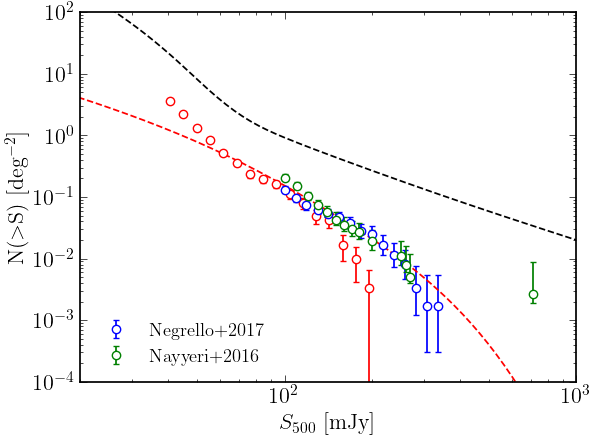

In [15]:
# Plot of cumulative lensed counts
plt.figure()
plt.errorbar(s_range, dr3_cum500, yerr = (dr3_cum500_low, dr3_cum500_high), c='r', marker = 'o', linestyle = '')
plt.errorbar(negrello_cum500['S'], negrello_cum500['Ngts'], yerr = (negrello_cum500['Ngts_low'], negrello_cum500['Ngts_high']), marker = 'o', linestyle = '', c='b', label =  'Negrello+2017')
plt.errorbar(nayyeri_cum500['S'], nayyeri_cum500['Ngts'], c='g', yerr = (nayyeri_cum500['Ngts_low'], nayyeri_cum500['Ngts_high']), marker = 'o', linestyle = '', label = 'Nayyeri+2016')
plt.plot(cai_cum500['S'], cai_cum500['total'], color = 'k', linestyle='--')
plt.plot(cai_cum500['S'], cai_cum500['Ngts_lensed'], color = 'r', linestyle = '--')
plt.loglog()
plt.xlim(2e1, 1e3)
plt.ylim(1e-4, 1e2)
plt.xlabel(r'$S_{500}$ [mJy]')
plt.ylabel(r'N($>$S) [deg$^{-2}$]')
plt.legend(loc = 'lower left')
plt.yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2])
plt.savefig(os.getcwd() + '/figures/Fig_11.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

We could now return to the redshift distribution shown above and now add plots for the lensed counts as well. We shall also compare the total and lensed z-distributions with those of Cai et al., 2013.

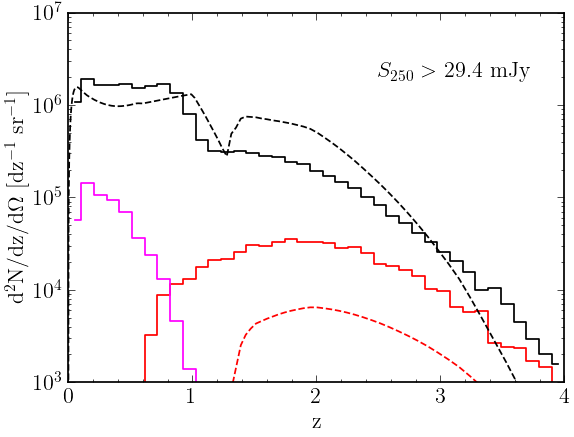

In [16]:
# Importing Cai et al, 2013 redshift models
cai_z250_slim294 = utils.full_loader('/cai_model_mu12/dNdz_250micron_mumax12_Slim294mJy')
cai_z250_slim294['dndz_total'] = (cai_z250_slim294['dndz_latetype'] + cai_z250_slim294['dndz_unlensed'] + cai_z250_slim294['dndz_lensed'])
cai_z250_slim294['log_z'] = np.log10(cai_z250_slim294['z'])

# Restricting our samples to the same flux limits
lensed_candidates_slim294 = lensed_candidates[lensed_candidates['F250BEST'] > flux_limit250/1000]
sources_zHELP_zHerschel_slim294 = sources_zHELP_zHerschel[sources_zHELP_zHerschel['F250BEST'] > flux_limit250/1000]

# Determine the redshift distributions
total_z_distribution_slim294, total_z_bins_slim294 = utils.dn_dz_domega(sources_zHELP_zHerschel_slim294['z_best'], min_z, max_z, z_bins, survey_area)
lens_z_distribution_slim294, lens_z_bins_slim294 = utils.dn_dz_domega(lensed_candidates_slim294['z1_median'], min_z, max_z, z_bins, survey_area)
source_z_distribution_slim294, source_z_bins_slim294 = utils.dn_dz_domega(lensed_candidates_slim294['Z_Herschel'], min_z, max_z, z_bins, survey_area)

#Plot of the different redshift distributions
plt.figure()
plt.step(total_z_bins_slim294, total_z_distribution_slim294, where = 'mid', color = 'k')
plt.step(source_z_bins_slim294, source_z_distribution_slim294, where = 'mid', color = 'r')
plt.step(lens_z_bins_slim294, lens_z_distribution_slim294, where = 'mid', color = 'magenta')
plt.plot(cai_z250_slim294['z'], cai_z250_slim294['dndz_total'], color = 'k', linestyle = '--')
plt.plot(cai_z250_slim294['z'], cai_z250_slim294['dndz_lensed'], color = 'r', linestyle = '--')
plt.text(2.5, 2e6, r'$S_{250} >$ 29.4 mJy')
plt.xlabel('z')
plt.ylabel(r'd$^2$N/dz/d$\Omega$ [dz$^{-1}$ sr$^{-1}$]')
plt.semilogy()
plt.xlim(0, 4)
plt.ylim(1e3, 1e7)
plt.yticks([1e3, 1e4, 1e5, 1e6, 1e7])
plt.savefig(os.getcwd() + '/figures/Fig_13.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

In [17]:
# Calculating the median redshifts of the distributions
lensed_source_zmedian = np.nanmedian(lensed_candidates['Z_Herschel'])
lensed_lens_zmedian = np.nanmedian(lensed_candidates['z1_median'])
best_zmedian = np.nanmedian(sources_zHELP_zHerschel['z_best'])

print("Median redshift of lensed sources = {:.3f}".format(lensed_source_zmedian))
print("Median redshift of lenses = {:.3f}".format(lensed_lens_zmedian))
print("Median redshift of best redshifts = {:.3f}".format(best_zmedian))

Median redshift of lensed sources = 2.028
Median redshift of lenses = 0.290
Median redshift of best redshifts = 0.623


We are also interested in determining the lensing fraction, the fraction of all sources that are lensed as a function
of 500um flux density.

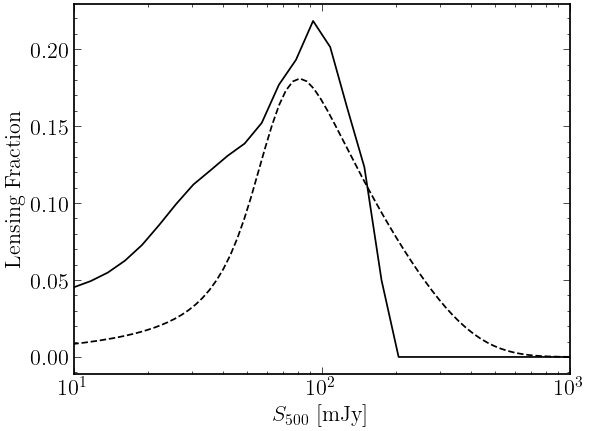

The number of sources with p > 0.94 at less than 100 mJy = 5923


In [18]:
# Define the lensing fraction from Cai et al. 2013
cai_lens_frac = (cai_cum500['Ngts_lensed'])/(cai_cum500['total'])

# Calculating the lensing fraction
s_range, dr3_lensing_fraction = utils.lensing_fraction(sources_zHELP_zHerschel, lensed_candidates, 'F500BEST', (10, 1000), 30, survey_area)

# Plot the lensing fraction
plt.figure()
plt.plot(s_range, dr3_lensing_fraction, color = 'k')
plt.plot(cai_cum500['S'], cai_lens_frac, linestyle = '--', color = 'k')
plt.xlim(1e1, 1e3)
plt.semilogx()
plt.xlabel(r'$S_{500}$ [mJy]')
plt.ylabel(r'Lensing Fraction')
plt.savefig(os.getcwd() + '/figures/Fig_12.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

# Calculate the number of sources (below 100 mJy) that have p > p_lens
print("The number of sources with p > {:.2f} at less than 100 mJy = {:.0f}".format(p_optimal, len(lensed_candidates_lt100)))

#### Comparison with HALOS

We define a sample of candidate lensed systems using the same criteria as the HALOS method and compare this to our sample. The HALOS criteria is given by:

- S350 >= 85 mJy
- S250 >= 35 mJy
- S350/S250 > 0.6
- S500/S350 > 0.4

In [19]:
# Definition of HALOS candidates
sources_HALOS = sources_zHELP_zHerschel[(sources_zHELP_zHerschel['F350BEST'] >= 0.085)
                                    & (sources_zHELP_zHerschel['F250BEST'] >= 0.035)
                                    & (sources_zHELP_zHerschel['F350BEST']/sources_zHELP_zHerschel['F250BEST'] > 0.6)
                                    & (sources_zHELP_zHerschel['F500BEST']/sources_zHELP_zHerschel['F350BEST'] > 0.4)]

In [20]:
# The number of HALOS sources
print('The number of sources satisfying HALOS criteria = {}'.format(len(sources_HALOS)))

# The number of HALOS systems with lensing probabilities
sources_HALOS_lensing_probabilities = sources_HALOS[sources_HALOS['p_lens'] > 0]
print('Number of sources from HALOS method that also have lensing probabilities = {:.0f}'.format(len(sources_HALOS_lensing_probabilities)))

sources_HALOS_gt_p_optimal = sources_HALOS[sources_HALOS['p_lens'] > p_optimal]
print('Number of sources from HALOS method that have lensing probabilities > {:.2f} = {:.0f}'.format(p_optimal, len(sources_HALOS_gt_p_optimal)))

The number of sources satisfying HALOS criteria = 654
Number of sources from HALOS method that also have lensing probabilities = 392
Number of sources from HALOS method that have lensing probabilities > 0.94 = 162


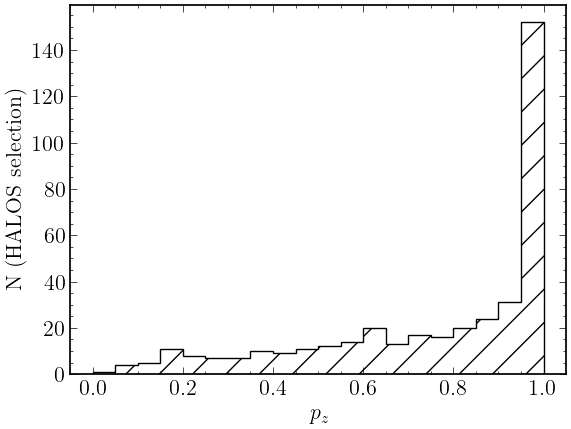

In [21]:
# HALOS sample histogram of p(lensing) values. The higher the value, the more trustworthy our selection criteria
plt.figure()
plt.hist(sources_HALOS_lensing_probabilities['p_lens'], bins = 20, range = (0, 1), histtype = 'step', hatch = '/')
plt.xlabel(r'$p_z$')
plt.ylabel(r'N (HALOS selection)')
plt.show()

---

### Genuine Multiple Counterparts

We are interested in determining the number of sources that are likely hosts to multiple systems. To determine this
value we consider all sources that have more than one object. We calculate the smallest redshift distance between
VIKING counterparts surrounding Herschel positions and the smallest redshift distance between VIKING counterparts
surrounding random positions. The subtraction of the latter from the former should give the number of sources for which
the closest pair of VIKING objects are truly due to the source.

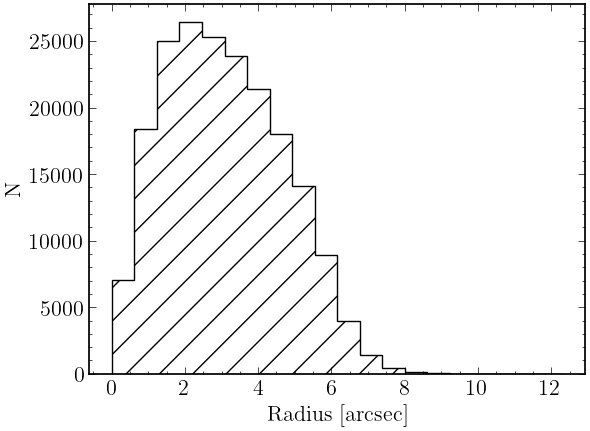

In [22]:
# The maximum distance that we find L > 0.66 counterparts
data_high_likelihood = data_zHELP[data_zHELP['likelihood'] > 0.66]

# Plot the distance of counterpart from source for L > 0.66 counterparts
plt.figure()
plt.hist(data_high_likelihood['DISTANCE'], bins = 20, histtype = 'step', hatch = '/')
plt.xlabel(r'Radius [arcsec]')
plt.ylabel(r'N')
plt.show()

We would like to compare the distribution of $\Delta_z$ for the data and background out to the same search radius.
From above it looks like we do not see many L > 0.66 counterparts beyond 8 arcsec. We shall restrict both calculations
of $\Delta_z$ to this radius.

In [23]:
# Restricting data and background to radius and computing multiples
maximum_r = 8
data_maximum_radius = data_zHELP[data_zHELP['DISTANCE'] <= maximum_r]
back_maximum_radius = back_zHELP[back_zHELP['DISTANCE'] <= maximum_r]
background_multiples = utils.genuine_multiples(back_zHELP, 'DISTANCE', 'GroupID', 'z1_median', 'z1_err', maximum_radius=maximum_r)
data_multiples = utils.genuine_multiples(data_zHELP, 'DISTANCE', 'GroupID', 'z1_median', 'z1_err', maximum_radius=maximum_r)

print('The number of sources with >= 2 candidates with photometric redshifts = {}'.format(np.count_nonzero(~np.isnan(data_multiples))))

Finding Pairs: 100%|██████████| 169461/169461 [00:21<00:00, 7799.79it/s] 


The number of sources with >= 2 candidates with photometric redshifts = 70880


Having calculated the closest pair of VIKING objects in both the background and data, we plot the two probability
density functions and do a background subtraction. The excess found at values close to delta(z) = 0 represents the
probability of Herschel sources that have genuine multiple counterparts and is found by fitting a Gaussian to the peak
and finding the area for the probability.

In [24]:
def fit_excess(data_multiples, background_multiples, n_bins, max_delta):
    """ FIT THE EXCESS DUE TO DATA MULTIPLES """

    data_multiples_histogram, bins = np.histogram(data_multiples, bins=n_bins, range=(-max_delta, max_delta), density=True)
    background_multiples_histogram, _ = np.histogram(background_multiples, bins=n_bins, range=(-max_delta, max_delta), density=True)

    # Determine the bin centers and true density
    bin_centre = [(bins[i] + bins[i+1])/2. for i in range(len(bins)-1)]
    true_density = data_multiples_histogram - background_multiples_histogram

    def gauss_function(x, a, x0, sigma, c):
        return a*np.exp(-(x-x0)**2/(2*sigma**2)) + c

    # Create a model for our excess histogram
    gaussian_model = Model(gauss_function)
    params = gaussian_model.make_params(a=0.1, x0=0, sigma=0.1, c=0)

    # Define model parameters and fit the model
    params['a'].vary = True
    params['x0'].vary = True
    params['sigma'].vary = True
    params['c'].vary = True
    fit_result = gaussian_model.fit(true_density, params, x = bin_centre)

    def gauss_true(x):
        return gauss_function(x, fit_result.params['a'].value, fit_result.params['x0'].value, fit_result.params['sigma'].value, fit_result.params['c'].value)

    # We expect the peak to be around +-0.1, from which we can calculate the area which estimates the probabilty
    guess1, guess2 = -0.1, 0.1
    root1, root2 = fsolve(gauss_true, guess1), fsolve(gauss_true, guess2)
    area, err = quad(gauss_true, root1, root2)

    return true_density, data_multiples_histogram, background_multiples_histogram, bin_centre, area, root1, root2

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_6158/3834163116.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


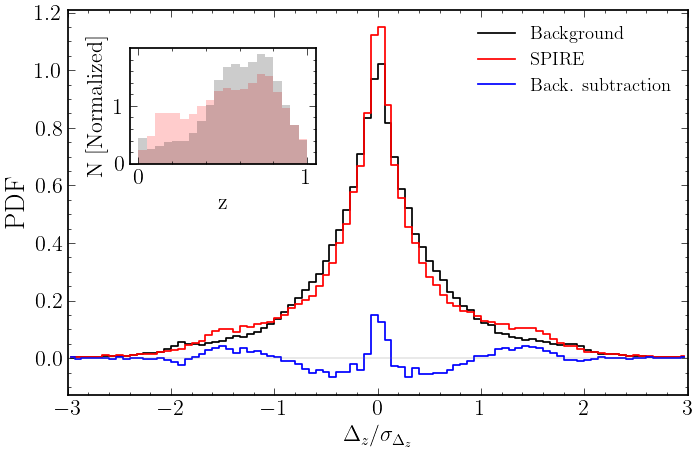

In [25]:
# Generate histograms from deltaz/error values
n_bins = 90
max_delta = 3

# Fit the excess values
true_density, data_multiples_histogram, background_multiples_histogram, bin_centre, area, root1, root2 = fit_excess(data_multiples, background_multiples, n_bins, max_delta)

# Plot of the data and background multiples as a function of delta(z)/sigma(delta(z))
delta_range = np.linspace(root1, root2, 1000)
fig, ax = plt.subplots(figsize = (8, 5))
ax.step(bin_centre, background_multiples_histogram, where = 'mid', label = 'Background')
ax.step(bin_centre, data_multiples_histogram, where = 'mid', label = 'SPIRE')
ax.step(bin_centre, true_density, where = 'mid', label = 'Back. subtraction')
ax.axhline(0, linestyle = '-', alpha = 0.2, color = 'grey')
ax.set_xlabel(r'$\Delta_z / \sigma_{\Delta_z}$')
ax.set_ylabel(r'PDF', fontsize = 20)
ax.set_xlim(-max_delta, max_delta)
ax.legend()
ax1 = ax.inset_axes([0.1, 0.6, 0.3, 0.3])
ax1.hist(data_maximum_radius['z1_median'], bins = 20, range = (0, 1), alpha = 0.2, color = 'r', density = True)
ax1.hist(back_maximum_radius['z1_median'], bins = 20, range = (0, 1), alpha = 0.2, color = 'k', density = True)
ax1.set_xlabel('z')
ax1.set_ylabel('N [Normalized]')
fig.savefig(os.getcwd() + '/figures/Fig_6.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
fig.show()

In [26]:
# N random iterations of bin number and maximum delta to find the range of probabilities
N = 1000
number_bins = []
delta_max = []
probability = []
n_multiples = []

for iteration in tqdm(range(N), desc = "Range of bin widths and maximum delta(z)"):
    bins_random = random.randint(75, 200)
    delta_random = random.uniform(0.5, 3)
    _, _, _, _, area, root1, root2 = fit_excess(data_multiples, background_multiples, bins_random, delta_random)
    sources_multi = [delta for delta in data_multiples if (delta > root1) & (delta < root2)]
    n_sources_multi = len(sources_multi)
    multiples = area*n_sources_multi
    number_bins.append(bins_random)
    delta_max.append(delta_random)
    probability.append(area)
    n_multiples.append(multiples)

Range of bin widths and maximum delta(z): 100%|██████████| 1000/1000 [03:53<00:00,  4.28it/s]


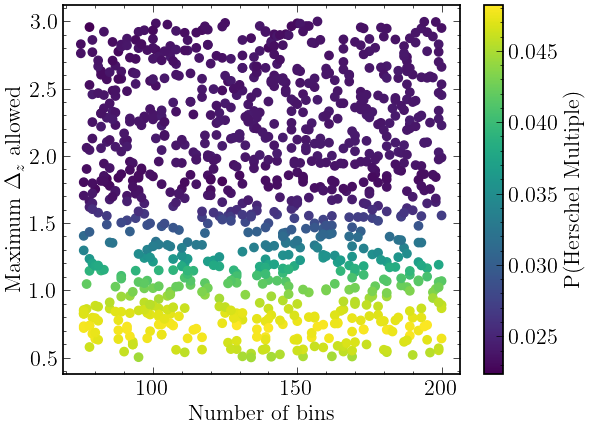

The probability a Herschel source is a multiple is estimated to be in the range 0.02 - 0.05
The number of Herschel multiples is estimated to be in the range 441 - 1031


In [27]:
# Plot of the range of values we estimate
plt.figure()
plt.scatter(number_bins, delta_max, c = probability)
plt.colorbar(label='P(Herschel Multiple)')
plt.xlabel(r'Number of bins')
plt.ylabel(r'Maximum $\Delta_z$ allowed')
plt.show()

print('The probability a Herschel source is a multiple is estimated to be in the range {:.2f} - {:.2f}'.format(min(probability), max(probability)))
print('The number of Herschel multiples is estimated to be in the range {:.0f} - {:.0f}'.format(min(n_multiples), max(n_multiples)))

---

### Outputting Final Tables

In [28]:
R = 15

# Output new data single IDs table
utils.save_file(sources_zHELP_zHerschel, 'output_files/HATLAS_SGP_DR3', R)